**IMPLEMENTATION OF DECISION TREE AND RANDOM FOREST**

**Use of the bank marketing data set to deploy a decision tree first and later a random forest algorithm in ordet to predict whether or not a bank customer is likely to subscrive to a term deposit given a set of 13 features**

In [4]:
from google.colab import files
uploaded = files.upload()

Saving bank.csv to bank.csv


In [0]:
import pandas as pd
import numpy as np
import io
bank = pd.read_csv(io.BytesIO(uploaded['bank.csv']))

In [6]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Description of data

Numerical Variables:

a) age

b) balance

c) day

d) duration

e) campaign

f) pdays

g) previous

Categorical Variables :

a) job : admin,technician, services, management, retired, blue-collar, unemployed, entrepreneur, housemaid, unknown, self-employed, student

b) marital : married, single, divorced

c) education: secondary, tertiary, primary, unknown

d) default : yes, no

e) housing : yes, no

f) loan : yes, no

g) deposit (has the client subscribed to a term deposit?) : yes, no (Dependent Variable)

h) contact : unknown, cellular, telephone

i) month : jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec

j) poutcome (outcome of previous marketing campaigns): unknown, other, failure, success

In [7]:
print(bank.isna().values.any())
null_values=bank.isna().sum().sort_values(ascending=False)
null_values

False


deposit      0
loan         0
job          0
marital      0
education    0
default      0
balance      0
housing      0
contact      0
poutcome     0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
age          0
dtype: int64

In [15]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


**Data cleaning**

In [0]:
# Some categories are going to be grouped together to streamline the analysis
bank['job'] = bank['job'].replace(['management', 'admin.'], 'white-collar')
bank['job'] = bank['job'].replace(['services','housemaid','unknown'], 'other')

In [0]:
bank['poutcome'] = bank['poutcome'].replace(['other'] , 'unknown')

In [0]:
#drop features that are not very relevant for the analysis
bank.drop('contact', axis=1, inplace=True)

Transforming categorical variables into numerical variables

In [11]:
cols = bank.columns
num_cols = bank._get_numeric_data().columns
categorical_variables = list(set(cols) - set(num_cols))
categorical_variables 

['marital',
 'education',
 'housing',
 'poutcome',
 'month',
 'default',
 'job',
 'deposit',
 'loan']

In [0]:
bank_numerical = pd.get_dummies(bank,columns=categorical_variables,drop_first=True)

In [13]:
num_cols

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

Data analysis more in details

Number of observations per classes of the target variable

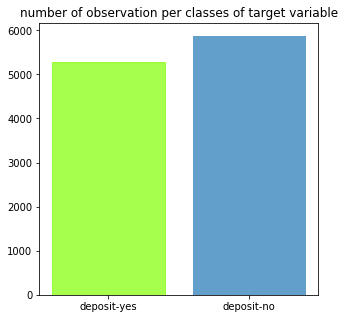

In [22]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

fig = plt.figure(figsize=(5,5))
#ax=fig.add_subplots(1,1,1)

a= (bank['deposit'][bank.deposit=='yes']).count()
b= (bank['deposit'][bank.deposit=='no']).count()

height = [a,b]
labels= ['deposit-yes', 'deposit-no']
y_pos = np.arange(len(labels))


barlist=plt.bar(y_pos, height, alpha=0.7)
barlist[0].set_color('chartreuse')
plt.xticks(y_pos, labels)
plt.title('number of observation per classes of target variable')
plt.show()

Distribution of numerical features in respect to the two classes of the targed variable

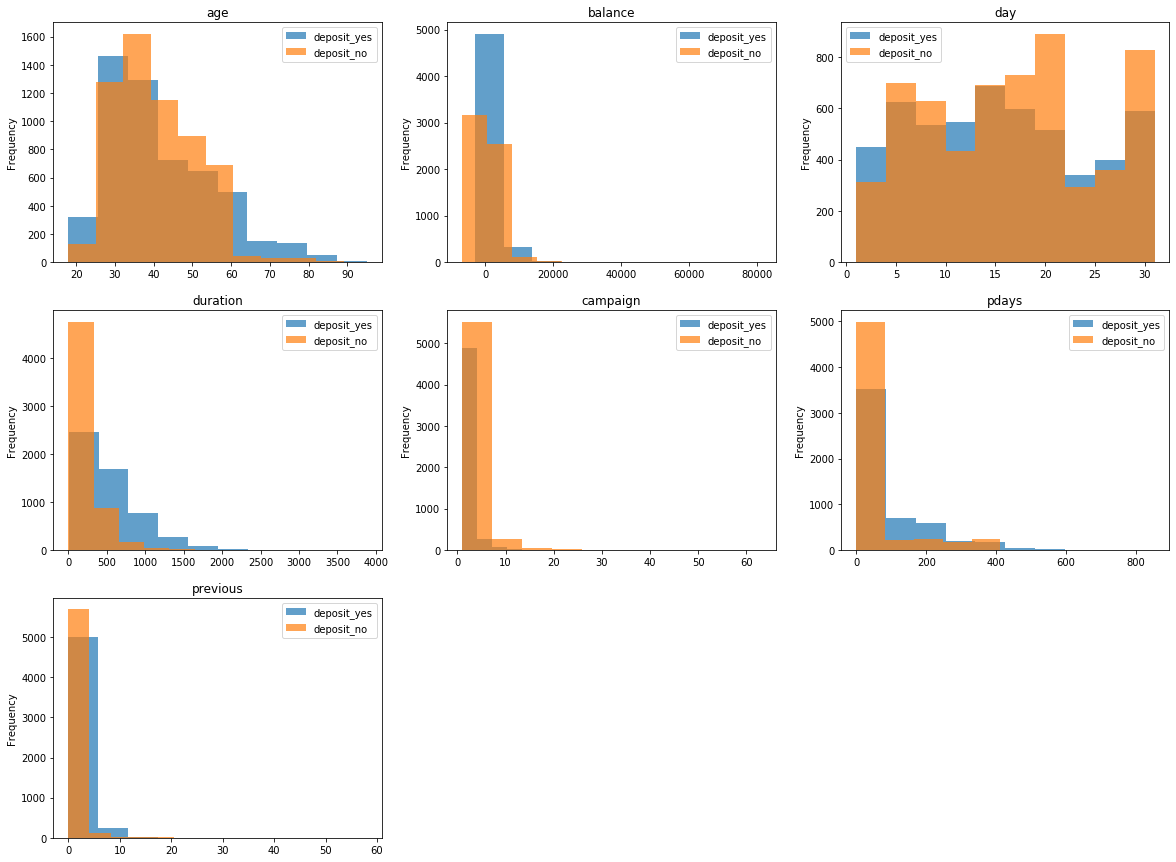

In [23]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

variables = num_cols 
plots = [num for num in range(len(num_cols))] 
deposits_yes = bank[(bank.deposit=='yes')]
deposits_no = bank[(bank.deposit=='no')]

fig = plt.figure(figsize=(20,15))
x = range(len(plots))

list_plots=[]
for num in x:
    plots[num]= fig.add_subplot(3,3,x[num]+1)
    list_plots.append(plots[num])
    
for i in x:
    list_plots[i].hist(deposits_yes[variables[i]],alpha = 0.7)
    list_plots[i].set_ylabel('Frequency')
    
for i in x:
    list_plots[i].hist(deposits_no[variables[i]],alpha = 0.7)
    list_plots[i].set_title(variables[i])
    list_plots[i].set_ylabel('Frequency')
    labels= ["deposit_yes","deposit_no"]
    list_plots[i].legend(labels)

Distibution of categorical features in relation to the two classes of the target variable

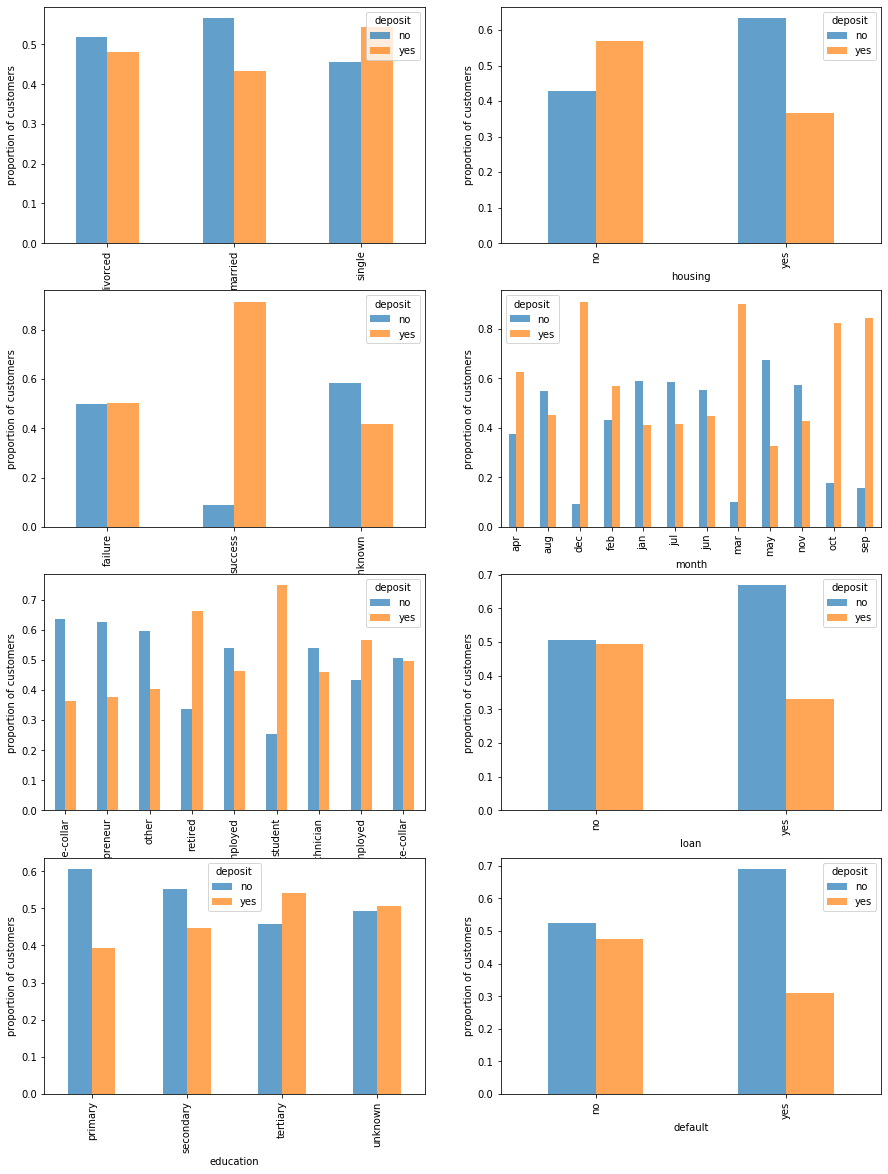

In [24]:
%matplotlib inline

cat_variables = [x for x in categorical_variables if x != 'deposit']

plots = [num for num in range(len(cat_variables))] 
tables= [str(x) for x in categorical_variables if x != 'deposit']

fig = plt.figure(figsize=(15,20))
x = range(len(plots))

list_plots=[]
list_tables=[]
for num in x:
    plots[num]= fig.add_subplot(4,2,x[num]+1)
    list_plots.append(plots[num])
    tables[num] = pd.crosstab(bank[cat_variables[num]],bank.deposit)
    list_tables.append(tables[num])
    
for i in x:
    list_tables[i].div(list_tables[i].sum(1).astype(float), axis=0).plot(kind='bar', ax= list_plots[i], alpha=0.7)             
    list_plots[i].set_ylabel('proportion of customers')

All the variables are not distributed equally amongst the two classes of the target variable 'deposit', hence they are all influential when determining one of the two outcome of the target variable

**Correlation Analysis**

In [25]:
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    #print(df.sort_values(by='corr',ascending=False))
    return df.sort_values(by='corr',ascending=False)

corrank(bank)

,pairs,corr
20,"(pdays, previous)",0.507272
12,"(day, campaign)",0.137007
0,"(age, balance)",0.112300
10,"(balance, previous)",0.030805
7,"(balance, duration)",0.022436
5,"(age, previous)",0.020169
9,"(balance, pdays)",0.017411
6,"(balance, day)",0.010467
4,"(age, pdays)",0.002774
2,"(age, duration)",0.000189


Correlations amongst variablenels are relatively low, which implies taht twe do not incur risks of multicollinearity affecting outcomes of the algorithm that are are about to implement

**Assigning numerical labels to categorical variables**

In [0]:
# first we are going to transform the target variable into a binary with values 0 and 1
bank['deposit']= np.where(bank.deposit=='yes',1, 0)

In [0]:
# we are now going to use one hot encoding to assiging numerical values to the categorical features

cat_variables = [x for x in categorical_variables if x != 'deposit']
bank_categorical = pd.get_dummies(bank,columns=cat_variables,drop_first=True)

In [16]:
bank_categorical.head()

,age,balance,day,duration,campaign,pdays,previous,deposit,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,housing_yes,poutcome_success,poutcome_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,default_yes,job_entrepreneur,job_other,job_retired,job_self-employed,job_student,job_technician,job_unemployed,job_white-collar,loan_yes
0,59,2343,5,1042,1,-1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,56,45,5,1467,1,-1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,41,1270,5,1389,1,-1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,55,2476,5,579,1,-1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,54,184,5,673,2,-1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


# **Part 1 - Implementation of Decision Tree**

In [0]:
y = bank_categorical['deposit']
X= bank_categorical.drop('deposit', axis = 1)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state=5)

In [0]:
#use Gridsearchcv to find the best parameters

params = {'max_leaf_nodes': list(range(2, 100)), 
          'min_samples_split': [2, 3, 4],
          'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
          'criterion':['entropy', 'gini']}
          
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

In [32]:
grid_search_cv.fit(X, y)

Fitting 3 folds for each of 6468 candidates, totalling 19404 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 19404 out of 19404 | elapsed: 13.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                     

In [33]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=73,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [34]:
grid_search_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_leaf_nodes': 73,
 'min_samples_split': 2}

In [0]:
from sklearn import tree

model_decisiontree= tree.DecisionTreeClassifier(criterion='entropy',max_depth=20, max_leaf_nodes=73, 
                                                min_samples_split=2,random_state=42)

model_decisiontree2= tree.DecisionTreeClassifier(criterion='entropy',max_depth=30, max_leaf_nodes=73, 
                                                min_samples_split=3,random_state=42)

model_decisiontree3= tree.DecisionTreeClassifier(criterion='gini',max_depth=20, max_leaf_nodes=73, 
                                                min_samples_split=2,random_state=42)

model_decisiontree4= tree.DecisionTreeClassifier(criterion='gini',max_depth=30, max_leaf_nodes=73, 
                                                min_samples_split=3,random_state=42)

In [20]:
model_decisiontree.fit(X_train, Y_train)
model_decisiontree2.fit(X_train, Y_train)
model_decisiontree3.fit(X_train, Y_train)
model_decisiontree4.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=30, max_features=None, max_leaf_nodes=73,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [0]:
import numpy as np
import os
np.random.seed(42)

# To plot the figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# A function to save the figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

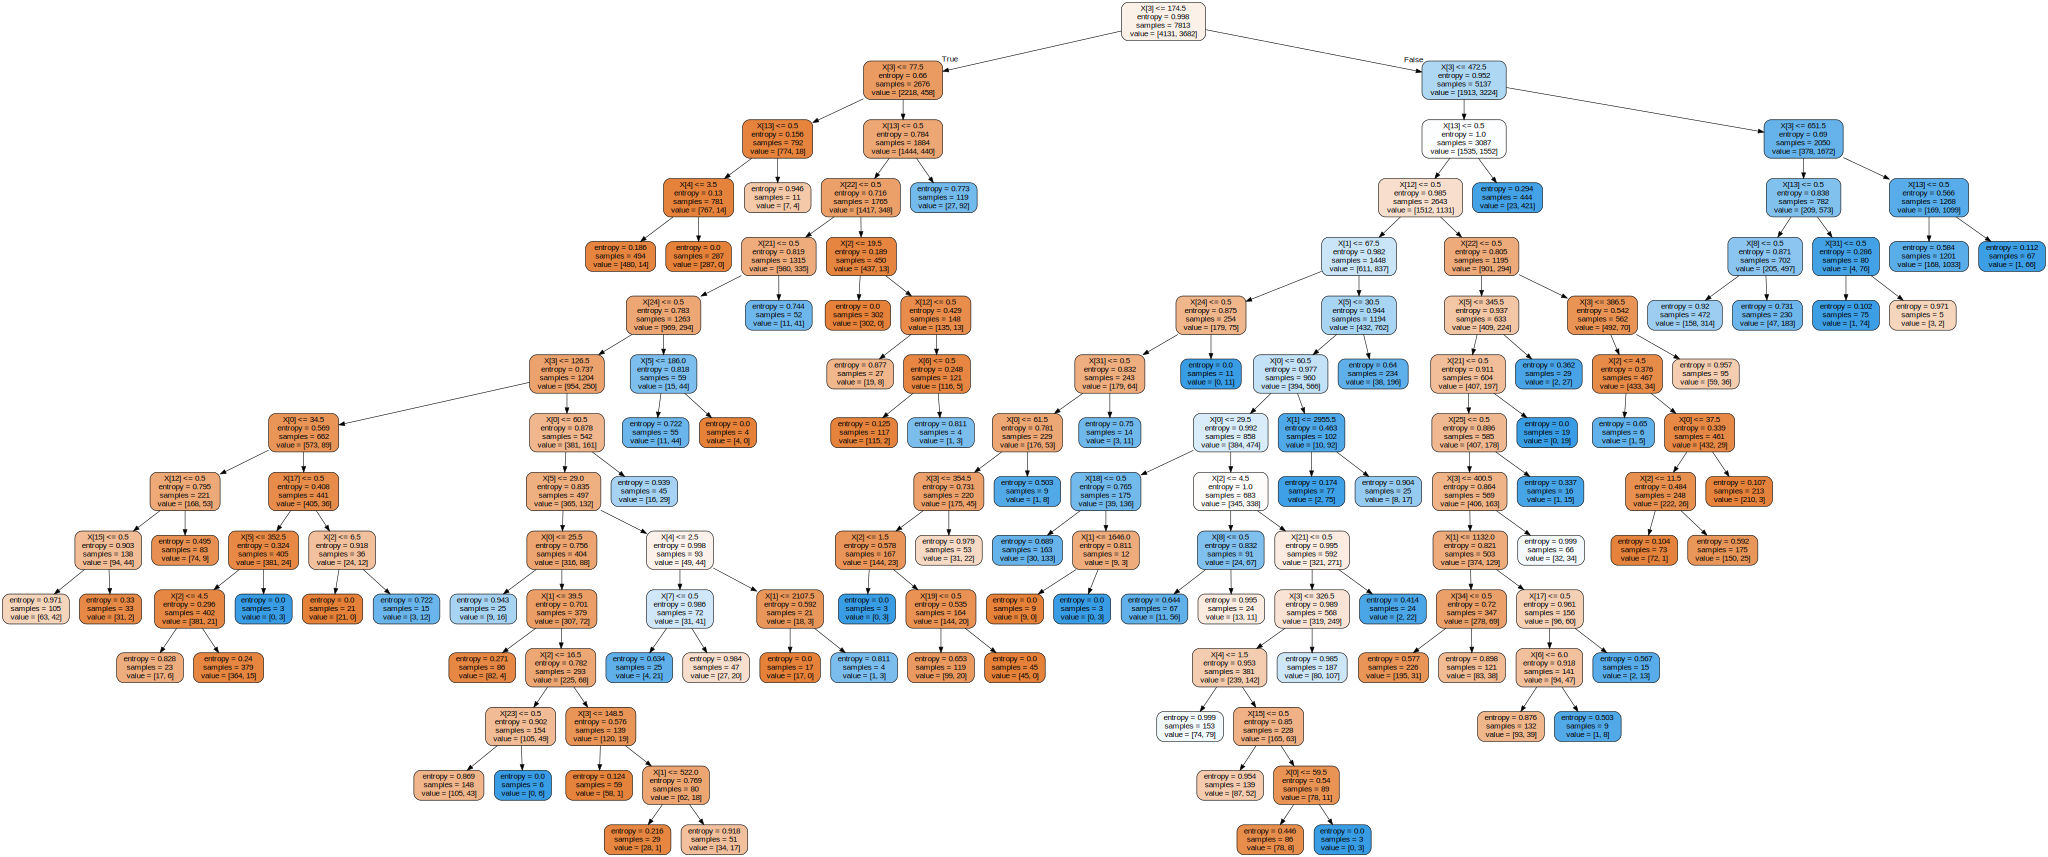

In [23]:
# Visualize the Decision Tree (you need to have graphviz installed)
from graphviz import Source
from sklearn.tree import export_graphviz
import os

# Call the export with Graphviz
export_graphviz(
        model_decisiontree,
        out_file=os.path.join(IMAGES_PATH, "moons_tree.dot"),
        feature_names=None,
        class_names=None,
        rounded=True,
        filled=True
    )

# Load the file in the notebook
Source.from_file(os.path.join(IMAGES_PATH, "moons_tree.dot"))

In [0]:
prediction=model_decisiontree.predict(X_test)
prediction2=model_decisiontree2.predict(X_test)
prediction3=model_decisiontree3.predict(X_test)
prediction4=model_decisiontree4.predict(X_test)

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(Y_test, prediction))
print(confusion_matrix(Y_test, prediction))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1742
           1       0.79      0.86      0.83      1607

    accuracy                           0.83      3349
   macro avg       0.83      0.83      0.83      3349
weighted avg       0.83      0.83      0.83      3349

[[1375  367]
 [ 217 1390]]


In [26]:
print(classification_report(Y_test, prediction2))
print(confusion_matrix(Y_test, prediction2))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1742
           1       0.79      0.86      0.83      1607

    accuracy                           0.83      3349
   macro avg       0.83      0.83      0.83      3349
weighted avg       0.83      0.83      0.83      3349

[[1375  367]
 [ 217 1390]]


In [27]:
print(classification_report(Y_test, prediction3))
print(confusion_matrix(Y_test, prediction3))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1742
           1       0.79      0.86      0.83      1607

    accuracy                           0.83      3349
   macro avg       0.83      0.83      0.83      3349
weighted avg       0.83      0.83      0.83      3349

[[1378  364]
 [ 220 1387]]


In [28]:
print(classification_report(Y_test, prediction4))
print(confusion_matrix(Y_test, prediction4))

              precision    recall  f1-score   support

           0       0.86      0.79      0.83      1742
           1       0.79      0.86      0.83      1607

    accuracy                           0.83      3349
   macro avg       0.83      0.83      0.83      3349
weighted avg       0.83      0.83      0.83      3349

[[1378  364]
 [ 220 1387]]


# **TO IMPROVE THE PREDICTION A RANDOM FOREST IS GOING TO BE IMPLEMENTED, IN ORDER TO IMPROVE THE CAPABILITY OF THE MODEL TO REDUCE BIAS AND GENERALIZE ON NEW (UNSEEN) DATA**

In [0]:
cat_variables = [x for x in categorical_variables if x != 'deposit']
bank_final= pd.get_dummies(bank,columns=cat_variables,drop_first=True)

In [30]:
bank_final.head()

,age,balance,day,duration,campaign,pdays,previous,deposit,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,housing_yes,poutcome_success,poutcome_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,default_yes,job_entrepreneur,job_other,job_retired,job_self-employed,job_student,job_technician,job_unemployed,job_white-collar,loan_yes
0,59,2343,5,1042,1,-1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,56,45,5,1467,1,-1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,41,1270,5,1389,1,-1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,55,2476,5,579,1,-1,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,54,184,5,673,2,-1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
y = bank_categorical['deposit']
X= bank_categorical.drop('deposit', axis = 1)

In [0]:
X_train, X_test, Y_train, Y_test =  train_test_split(X, y, test_size = 0.3, random_state=5)

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
#use Gridsearchcv to find the best parameters

params = {'max_depth': [10,30,50, 70,100, None],
          'max_features': ['auto', 'sqrt'],
          'min_samples_leaf': [1, 2, 4],
          'n_estimators': [100,500,1000, 1500, 2000]}
          
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)

In [50]:
grid_search_cv.fit(X, y)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 88.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [51]:
grid_search_cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [52]:
grid_search_cv.best_params_

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'n_estimators': 2000}

In [0]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [35]:
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
predictions = rf.predict(X_test)

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.82      0.85      1742
           1       0.82      0.90      0.86      1607

    accuracy                           0.86      3349
   macro avg       0.86      0.86      0.86      3349
weighted avg       0.86      0.86      0.86      3349

[[1424  318]
 [ 166 1441]]


In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

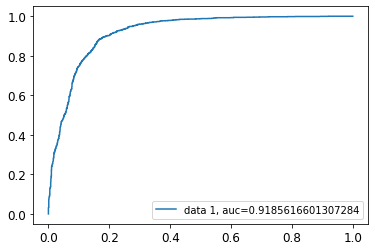

In [43]:
from sklearn import metrics
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [45]:
print("Area under the curve:", round(auc,2))

Area under the curve: 0.92
